#### Packages 

In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import mlflow
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle
from model_utils import *

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")

#### Install Optuna and Scikit optmize

In [3]:
# %pip install optuna
# %pip install scikit-optimize

In [3]:
df_train, df_test = get_raw_data()

In [4]:
clf1 = setup(data = df_train, 
             target = 'target',
             numeric_features=df_train.columns[0:-1].to_list(),
             silent=True,
             log_experiment = True,
             use_gpu=False,
             experiment_name = 'selected_model',
             fix_imbalance = True, 
             transformation = True, 
             polynomial_features = True,
             feature_selection = True, feature_selection_threshold = 0.5,
             remove_multicollinearity = True, multicollinearity_threshold = 0.6,
            )
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba')
best = compare_models(sort="APC", 
                      include=["lightgbm", "et", "rf", "lr", "gbc"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9751,0.9782,0.8761,0.9472,0.9097,0.8953,0.8966,0.9509,1.9780
et,Extra Trees Classifier,0.9764,0.9777,0.8583,0.9761,0.9118,0.8983,0.9018,0.9506,0.2920
rf,Random Forest Classifier,0.9777,0.9785,0.8672,0.9773,0.9173,0.9045,0.9077,0.9505,0.5590
gbc,Gradient Boosting Classifier,0.9681,0.9741,0.8717,0.9078,0.8865,0.8679,0.8701,0.9461,1.4110
lr,Logistic Regression,0.9572,0.9720,0.8984,0.8266,0.8583,0.8333,0.8361,0.9429,0.0410


In [5]:
clf1

(False,
 '5316',
 Pipeline(memory=None,
          steps=[('fix_imbalance',
                  SMOTE(k_neighbors=5, n_jobs=None, random_state=8364,
                        sampling_strategy='auto'))],
          verbose=False),
 False,
 10,
 True,
 True,
 'lightgbm',
                                      Model  Accuracy     AUC  Recall   Prec.  \
  lightgbm  Light Gradient Boosting Machine    0.9751  0.9782  0.8761  0.9472   
  et                 Extra Trees Classifier    0.9764  0.9777  0.8583  0.9761   
  rf               Random Forest Classifier    0.9777  0.9785  0.8672  0.9773   
  gbc          Gradient Boosting Classifier    0.9681  0.9741  0.8717  0.9078   
  lr                    Logistic Regression    0.9572  0.9720  0.8984  0.8266   
  
                F1   Kappa     MCC     APC  TT (Sec)  
  lightgbm  0.9097  0.8953  0.8966  0.9509     1.978  
  et        0.9118  0.8983  0.9018  0.9506     0.292  
  rf        0.9173  0.9045  0.9077  0.9505     0.559  
  gbc       0.8865  0.8679

In [6]:
best

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8364, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [7]:
results = predict_model(best, raw_score=True,data = df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Light Gradient Boosting Machine,0.9746,0.9840,0.9006,0.9333,0.9167,0.9017,0.9019,0.9630


#### Hyperparameter tuning
Define search space for hyper parameter tuning

In [8]:
params = {"max_depth": np.random.randint(1, 40, 10),
          "n_estimators": np.random.randint(2, 1000, 10)}
          
# tune model
tuned_dt = tune_model(best, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9745,0.9705,0.8261,1.0000,0.9048,0.8902,0.8956,0.9414
1,0.9618,0.9491,0.8261,0.9048,0.8636,0.8415,0.8426,0.9022
2,0.9936,0.9990,0.9565,1.0000,0.9778,0.9741,0.9744,0.9950
3,0.9554,0.9721,0.7826,0.9000,0.8372,0.8115,0.8142,0.9171
4,0.9745,0.9912,0.8696,0.9524,0.9091,0.8943,0.8956,0.9722
5,0.9872,0.9824,0.9091,1.0000,0.9524,0.9450,0.9464,0.9530
6,0.9744,0.9634,0.8636,0.9500,0.9048,0.8900,0.8913,0.9155
7,0.9872,0.9898,0.9545,0.9545,0.9545,0.9471,0.9471,0.9738
8,0.9808,0.9593,0.8636,1.0000,0.9268,0.9158,0.9191,0.9190


In [9]:
tuned_dt

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=691, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8364, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
results = predict_model(tuned_dt, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Light Gradient Boosting Machine,0.9773,0.9849,0.9064,0.9451,0.9254,0.9120,0.9123,0.9658


#### Voting classifier

In [11]:
tops= compare_models(n_select = 3, sort="APC")
tops

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9751,0.9782,0.8761,0.9472,0.9097,0.8953,0.8966,0.9509,0.3330
et,Extra Trees Classifier,0.9764,0.9777,0.8583,0.9761,0.9118,0.8983,0.9018,0.9506,0.3740
rf,Random Forest Classifier,0.9777,0.9785,0.8672,0.9773,0.9173,0.9045,0.9077,0.9505,0.6270
gbc,Gradient Boosting Classifier,0.9681,0.9741,0.8717,0.9078,0.8865,0.8679,0.8701,0.9461,1.4040
lr,Logistic Regression,0.9572,0.9720,0.8984,0.8266,0.8583,0.8333,0.8361,0.9429,1.6660
lda,Linear Discriminant Analysis,0.9706,0.9734,0.8850,0.9141,0.8966,0.8795,0.8815,0.9410,0.0330
ada,Ada Boost Classifier,0.9623,0.9615,0.8846,0.8619,0.8715,0.8495,0.8506,0.9293,0.4200
knn,K Neighbors Classifier,0.9566,0.9657,0.8893,0.8253,0.8549,0.8294,0.8311,0.8968,0.0710
qda,Quadratic Discriminant Analysis,0.9681,0.9467,0.8628,0.9150,0.8852,0.8668,0.8692,0.8910,0.0320
nb,Naive Bayes,0.9636,0.9648,0.8806,0.8710,0.8748,0.8536,0.8542,0.8549,0.0260


[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=8364, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=8364, verbose=0,
                      warm_start=F

In [12]:
tops[0]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8364, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
blender_weighted = blend_models([tops[0],tops[1],tops[2]], weights = [0.5,0.3,0.2])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9745,0.9883,0.8261,1.0000,0.9048,0.8902,0.8956,0.9571
1,0.9554,0.9471,0.8261,0.8636,0.8444,0.8184,0.8187,0.8997
2,0.9936,0.9990,0.9565,1.0000,0.9778,0.9741,0.9744,0.9950
3,0.9682,0.9650,0.7826,1.0000,0.8780,0.8600,0.8686,0.9043
4,0.9745,0.9818,0.8696,0.9524,0.9091,0.8943,0.8956,0.9596
5,0.9872,0.9827,0.9091,1.0000,0.9524,0.9450,0.9464,0.9631
6,0.9808,0.9813,0.8636,1.0000,0.9268,0.9158,0.9191,0.9439
7,0.9936,0.9969,0.9545,1.0000,0.9767,0.9730,0.9734,0.9868
8,0.9744,0.9583,0.8182,1.0000,0.9000,0.8855,0.8913,0.9338


In [14]:
tops= compare_models(n_select = 2)
blender = blend_models(tops)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9682,0.9886,0.7826,1.0000,0.8780,0.8600,0.8686,0.9585
1,0.9554,0.9447,0.8261,0.8636,0.8444,0.8184,0.8187,0.8979
2,0.9873,0.9994,0.9565,0.9565,0.9565,0.9491,0.9491,0.9965
3,0.9682,0.9627,0.7826,1.0000,0.8780,0.8600,0.8686,0.9022
4,0.9809,0.9818,0.8696,1.0000,0.9302,0.9192,0.9222,0.9598
5,0.9872,0.9829,0.9091,1.0000,0.9524,0.9450,0.9464,0.9631
6,0.9808,0.9815,0.8636,1.0000,0.9268,0.9158,0.9191,0.9431
7,0.9936,0.9973,0.9545,1.0000,0.9767,0.9730,0.9734,0.9879
8,0.9744,0.9573,0.8182,1.0000,0.9000,0.8855,0.8913,0.9346


#### Hyperparameter tuning with scikit-optimize on voting model

PyCaret integrates seamlessly with many different libraries for hyperparameter tuning. This gives you access to many different types of search algorithms including random, bayesian, optuna, TPE, and a few others. All of this just by changing a parameter. By default, PyCaret using RandomGridSearch from the sklearn and you can change that by using search_library and search_algorithm parameter in the tune_model function.

In [15]:
tuned_dt = tune_model(blender_weighted, search_library = 'scikit-optimize', optimize="APC", n_iter = 50) # https://pycaret.readthedocs.io/en/stable/api

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
Fold,,,,,,,,
0,0.9618,0.9870,0.7391,1.0000,0.8500,0.8287,0.8411,0.9562
1,0.9554,0.9409,0.8261,0.8636,0.8444,0.8184,0.8187,0.8967
2,0.9873,0.9997,0.9565,0.9565,0.9565,0.9491,0.9491,0.9982
3,0.9682,0.9640,0.7826,1.0000,0.8780,0.8600,0.8686,0.9072
4,0.9809,0.9789,0.8696,1.0000,0.9302,0.9192,0.9222,0.9581
5,0.9872,0.9854,0.9091,1.0000,0.9524,0.9450,0.9464,0.9665
6,0.9808,0.9810,0.8636,1.0000,0.9268,0.9158,0.9191,0.9461
7,0.9936,0.9976,0.9545,1.0000,0.9767,0.9730,0.9734,0.9890
8,0.9679,0.9617,0.8182,0.9474,0.8780,0.8597,0.8628,0.9384


In [16]:
results = predict_model(tuned_dt, raw_score=True, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Voting Classifier,0.9755,0.9806,0.8772,0.9615,0.9174,0.9031,0.9044,0.9606


In [17]:
save_model(tuned_dt, 'tuned_dt')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['Time', 'V1', 'V2',
                                                           'V3', 'V4', 'V5',
                                                           'V6', 'V7', 'V8',
                                                           'V9', 'V10', 'V11',
                                                           'V12', 'V13', 'V14',
                                                           'V15', 'V16', 'V17',
                                                           'V18', 'V19', 'V20',
                                                           'V21', 'V22', 'V23',
                                                   

In [18]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

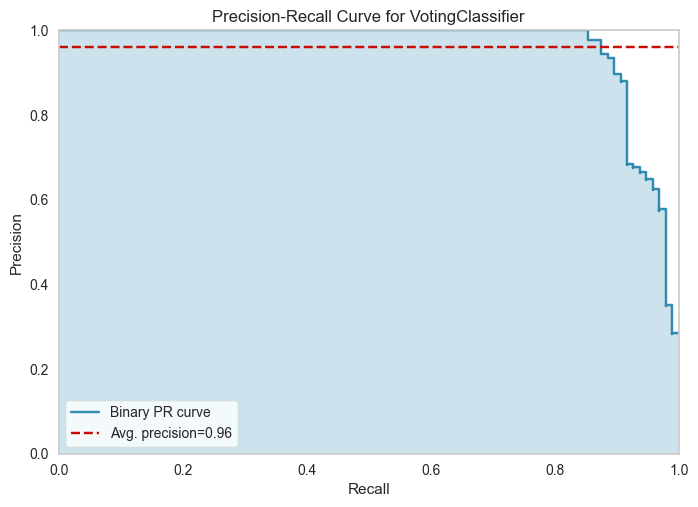

In [19]:
plot_model(tuned_dt, plot = 'pr')

#### Create REST API

In [20]:
# %pip install fastapi
# %pip install uvicorn

In [21]:
create_api(tuned_dt, 'fraud_voting_model_api')


API sucessfully created. This function only creates a POST API, it doesn't run it automatically.

To run your API, please run this command --> !python fraud_voting_model_api.py
    


In [22]:
df_test.iloc[-1]

Time      41991.000000
V1           -4.566342
V2            3.353451
V3           -4.572028
V4            3.616119
V5           -2.493138
V6           -1.090000
V7           -5.551433
V8            0.447783
V9           -2.424414
V10          -5.699922
V11           3.586824
V12          -6.636229
V13          -1.128176
V14          -7.245550
V15           0.638326
V16          -6.856810
V17          -8.851879
V18          -4.591883
V19           0.936940
V20          -0.249128
V21           2.674466
V22          -0.020880
V23          -0.302447
V24          -0.086396
V25          -0.516060
V26          -0.295102
V27           0.195985
V28           0.141115
Amount        1.000000
target        1.000000
Name: 44556, dtype: float64

#### Create Docker

In [23]:
create_docker('fraud_voting_model_api')

Writing requirements.txt
Writing Dockerfile
Dockerfile and requirements.txt successfully created.
To build image you have to run --> !docker image build -f "Dockerfile" -t IMAGE_NAME:IMAGE_TAG .
        


In [25]:
# !docker image build -f Dockerfile -t fraud_voting_model_api:latest .
!docker image build -f "Dockerfile" -t fraud_voting_model_api:latest .

#1 [internal] load build definition from Dockerfile
#1 sha256:752698380b6c52a095d1b1c921ffead9cacd4aaa74c6ff997fef4ad1760a5b4e
#1 transferring dockerfile: 257B 0.1s done
#1 DONE 0.1s

#2 [internal] load .dockerignore
#2 sha256:b73c4a17d0600d238eee13d5e75cd3dd5369e77e6104083c1945587da491786a
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/library/python:3.8-slim
#3 sha256:a94c831f6b826f8ffd4325edd7e9f6408caa85fd7f03e2b107cc6a9d249f7065
#3 ...

#4 [auth] library/python:pull token for registry-1.docker.io
#4 sha256:5cba492fb01746c3dc45d5cabca61d6fe9bcb472e3c686e7dee90534df5e90e7
#4 DONE 0.0s

#3 [internal] load metadata for docker.io/library/python:3.8-slim
#3 sha256:a94c831f6b826f8ffd4325edd7e9f6408caa85fd7f03e2b107cc6a9d249f7065
#3 DONE 3.8s

#10 [1/5] FROM docker.io/library/python:3.8-slim@sha256:1222aecd5ea9214a0ca4761e21f9f36d119c55a5a3721cd06da58e7199e79f2e
#10 sha256:7a2ab8c8bb7b2edf5e64b18c26918875d8baf851f9ffeb85421198067ec59878
#10 DONE 0

In [28]:
!docker run -d -p 8000:8000 --name fraud_voting_model_api fraud_voting_model_api:latest

1140b98eb6e96c9c9bdbd3e83cb4dd6488d32afa0e1f4aba5d6f82510098f9b7
